In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, MaxPooling1D, Conv2D, Conv1D, Flatten, Dropout, SpatialDropout1D, SimpleRNN, GRU, LSTM
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import random
import pandas as pd
import time
import pickle
import copy

Using TensorFlow backend.


In [2]:
def make_time_series(data):
    data1 = []
    for i in data:
        data1.append(np.transpose(i))
    return np.array(data1)

In [3]:
def transpose_scale(arr,num):
    arr2 = copy.deepcopy(arr)
    arr2 = np.roll(arr2,-num,axis = 0)
    if int(num/abs(num))==1:
        for i in range(num):
            arr2[-(i+1)] = np.zeros(len(arr2[0]))
    else:
        for i in range(abs(num)):
            arr2[i] = np.zeros(len(arr2[0]))
    return arr2

In [4]:
def translate_time(arr,num):
    
    arr2 = copy.deepcopy(arr)
    arr2 = np.transpose(arr2)
    arr2 = np.roll(arr2,-num,axis = 0)
    if int(num/abs(num))==1:
        for i in range(num):
            arr2[-(i+1)] = np.zeros(len(arr2[0]))
    else:
        for i in range(abs(num)):
            arr2[i] = np.zeros(len(arr2[0]))
            
    return np.transpose(arr2)

# 3^{o} Classification (Bach+Mozart+Beethoven)

# Reading and creating the Datasets

In [5]:
#reading the training rolls and training labels
training_rolls = []
training_labels = []
for i in range(1202):
    filename1 = '/kaggle/input/prollnpy3/train_rolls/train_rolls/train_roll' + str(i) + '.npy'
    filename2 = '/kaggle/input/prollnpy3/train_labels/train_labels/train_label' + str(i) + '.npy'
    temp1 = np.load(filename1)
    temp2 = np.load(filename2)
    training_rolls.append(temp1)
    training_labels.append(temp2)
    
for i in range(len(training_labels)):
    if training_labels[i]==3:
        training_labels[i] = 2

In [6]:
#reading the test rolls and test labels
test_rolls = []
test_labels = []
for i in range(301):
    filename1 = '/kaggle/input/prollnpy3/test_rolls/test_rolls/test_roll' + str(i) + '.npy'
    filename2 = '/kaggle/input/prollnpy3/test_labels/test_labels/test_label' + str(i) + '.npy'
    temp1 = np.load(filename1)
    temp2 = np.load(filename2)
    test_rolls.append(temp1)
    test_labels.append(temp2)
    
for i in range(len(test_labels)):
    if test_labels[i]==3:
        test_labels[i] = 2  

In [7]:
training_rolls = np.array(training_rolls)
test_rolls = np.array(test_rolls)
training_labels = np.array(training_labels)
test_labels = np.array(test_labels)

# Transposition & translation

In [8]:
temp1 = []
temp2 = []
for i in range(len(training_rolls)):
    temp1.append(transpose_scale(training_rolls[i],20))
    temp1.append(transpose_scale(training_rolls[i],40))
    temp1.append(translate_time(training_rolls[i],100))
    temp1.append(translate_time(training_rolls[i],-100))
                                
    temp1.append(transpose_scale(training_rolls[i],-40))
    temp1.append(translate_time(training_rolls[i],200))
    temp2.append(training_labels[i])
    temp2.append(training_labels[i])
    temp2.append(training_labels[i])
    temp2.append(training_labels[i])
    temp2.append(training_labels[i])
    temp2.append(training_labels[i])
    
temp1 = np.array(temp1)
temp2 = np.array(temp2)
training_rolls = np.concatenate([training_rolls,temp1])
training_labels = np.concatenate([training_labels,temp2])

# temp1 = []
# temp2 = []
# for i in range(len(test_rolls)):
#     temp1.append(transpose_scale(test_rolls[i],4))
#     temp1.append(transpose_scale(test_rolls[i],-4))
#     temp1.append(translate_time(test_rolls[i],4))
#     temp1.append(translate_time(test_rolls[i],-4))
#     temp2.append(test_labels[i])
#     temp2.append(test_labels[i])
#     temp2.append(test_labels[i])
#     temp2.append(test_labels[i])
    
# temp1 = np.array(temp1)
# temp2 = np.array(temp2)
# test_rolls = np.concatenate([test_rolls,temp1])
# test_labels = np.concatenate([test_labels,temp2])

In [9]:
c = list(zip(training_rolls, training_labels))

random.shuffle(c)

training_rolls, training_labels = zip(*c)


d = list(zip(test_rolls, test_labels))

random.shuffle(d)

test_rolls, test_labels = zip(*d)

In [10]:
len(training_labels)

8414

# Now it begins

In [11]:
num_classes = 3

piano_roll_shape = training_rolls[0].shape
piano_roll_size = piano_roll_shape[0]*piano_roll_shape[1]

In [12]:

training_labels = to_categorical(training_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

In [13]:

(x_train,x_test) = (make_time_series(training_rolls),make_time_series(test_rolls))

In [14]:
training_rolls = None
test_rolls = None

# Conv1D + GRU

In [15]:
model = Sequential()
#model.add(Embedding(2**piano_roll_shape[0], piano_roll_shape[0], input_length=piano_roll_shape[1])) 
#model.add(SpatialDropout1D(drop_embed))
model.add(Conv1D(128, 4, activation='selu', input_shape=(piano_roll_shape[1],piano_roll_shape[0])))
model.add(Conv1D(128, 4, activation='selu', input_shape=(piano_roll_shape[1],piano_roll_shape[0])))
model.add(MaxPooling1D(4))
model.add(GRU(512, activation = 'selu', dropout = 0.1))
#model.add(Conv1D(64, 4, activation='selu')
#model.add(SimpleRNN(128, activation = 'relu', return_sequences=True, dropout=drop_rnn))
#model.add(SimpleRNN(64, activation = 'relu', return_sequences=True, dropout=drop_rnn))
#model.add(SimpleRNN(64, activation = 'relu', dropout=drop_rnn))
model.add(Dense(64, activation='selu'))
model.add(Dropout(0.1))
# model.add(Dense(1, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
early_stopper = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 697, 128)          36480     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 694, 128)          65664     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 173, 128)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 512)               984576    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                

In [16]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, training_labels, batch_size=64, epochs=25, verbose=1, validation_split=.15,callbacks=[early_stopper])

Train on 7151 samples, validate on 1263 samples
Epoch 1/25
7151/7151 [==============================] - 64s 9ms/step - loss: 1.4088 - accuracy: 0.3839 - val_loss: 1.0662 - val_accuracy: 0.4086
Epoch 2/25
7151/7151 [==============================] - 60s 8ms/step - loss: 1.0901 - accuracy: 0.4598 - val_loss: 1.0141 - val_accuracy: 0.4727
Epoch 3/25
7151/7151 [==============================] - 60s 8ms/step - loss: 0.9894 - accuracy: 0.5296 - val_loss: 0.9861 - val_accuracy: 0.5202
Epoch 4/25
7151/7151 [==============================] - 59s 8ms/step - loss: 0.8441 - accuracy: 0.6213 - val_loss: 0.8601 - val_accuracy: 0.6057
Epoch 5/25
7151/7151 [==============================] - 59s 8ms/step - loss: 0.7253 - accuracy: 0.6932 - val_loss: 0.8746 - val_accuracy: 0.6326
Epoch 6/25
7151/7151 [==============================] - 59s 8ms/step - loss: 0.6441 - accuracy: 0.7368 - val_loss: 0.8943 - val_accuracy: 0.6770
Epoch 7/25
7151/7151 [==============================] - 59s 8ms/step - loss: 0.567

301/301 [==============================] - 0s 2ms/step


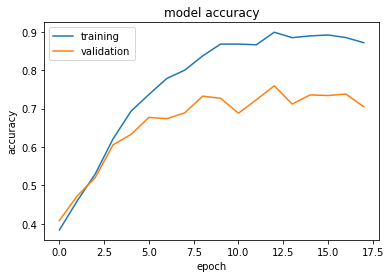

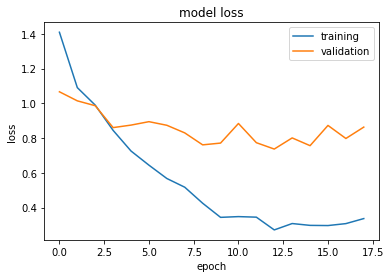

Test loss: 1.3
Test accuracy: 0.694


In [17]:
loss, accuracy  = model.evaluate(x_test, test_labels, verbose=True)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

plt.savefig('/kaggle/working/trinary_GRU.png',dpi=300)

plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [18]:
# When did our evaluator do poorly?
predictions = model.predict(x_test)


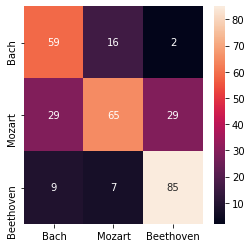

In [20]:
cm = confusion_matrix(np.argmax(predictions, axis=1), np.argmax(test_labels, axis=1))
plt.figure(figsize = (4, 4))

name_labels = ['Bach', 'Mozart', 'Beethoven']

sn.heatmap(cm, annot=True, xticklabels=name_labels, yticklabels=name_labels)
plt.savefig('/kaggle/working/confu.png',dpi=300)

plt.show()